Under the supervision of   
Miguel Colom,  
Rafael Grompone von Gioi,  
Argyris Kalogeratos

École normale supérieure Paris-Saclay (ENS Paris-Saclay)


# <center>Quasi-Newton methods and constrained optimization</center>

# Application of a quasi-Newton method with the Broyden-Fletcher-Goldfarb-Shanno (BFGS)

In this exercise we will use the quasi-Newton method to solve a simple prediction problem. Moreover, you will verify experimentally that the BFGS correction allows to converge faster to a minimum.

Let's imagine that we are data scientists working in a bank and we would like to know if it would be good idea to grant or not a loan to a new client according to the expected risk of not being paid back. The bank keeps a record of previous requests of clients, so there are collected data that are available. In this exercise, the dataset comes from the [UCI German Dataset](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)).

The German dataset has one individual client per row, whose recorded request is
described by several attributes. Examples of attributes are: how many years
unemployed, the purpose of the credit (e.g. to buy a new car, repairs,
vacation...), age, etc. The last column tells if granting the credit to the
client was a good choice (for the bank...) or not. The aim is to learn the way
financial experts have decided for past cases in order to be able to
automatically answer for future requests.

We will consider a function (usually known as the _loss function_ in the machine learning context) that takes as parameters the attributes of a client and makes a binary prediction (the bank should grant the loan, or the bank should not). We can formalize the evaluation of the function as a simple dot product: $$x^\top \omega,$$ where $x$ is the vector with the attributes of a request and $\omega$ is the vector with the coefficients of the loss function we want to minimize.

As typical in the field of machine learning, we will consider a _training_ dataset that will be used to "train" our model and a _test_ dataset to later evaluate our trained model. During the training phase, we will apply the quasi-Newton method to effectively learn coefficients in $\omega$ that minimize the loss function. Once this coefficients have been learned, we will evaluate the function with the test dataset.

Here we consider a "logistic loss" function which is implemented by the following class. The details are beyond the scope of this exercise, and you may think from now on that your objective is simply to minimize this function.

In [ ]:
# Import basic packages
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt

In [ ]:
class LogisticLoss():
    def __init__(self, x_train, y_train, x_test, y_test, reg=10**-2):
        '''
        Constructor
        '''
        self.x_train = x_train
        self.y_train = y_train
        #
        self.x_test = x_test
        self.y_test = y_test
        #
        self.reg = reg
        self.ndim = x_train.shape[0]

    def sigmoid(self, x):
        '''
        Sigmoid function
        '''
        return 1 / (1 + np.exp(-x))

    def logistic_function(self, x):
        '''
        Logistic function (single value)
        '''
        return np.log(1 + np.exp(-x))

    def evaluate(self, omega, x):
        '''
        Evaluate function omega at x
        '''
        return x.dot(omega)

    def log_fun(self, omega):
        '''
        Logistic loss of function omega in the training set
        '''
        scal = self.evaluate(omega, x_train)
        val = self.y_train * scal
        loss_n = self.logistic_function(val)
        loss = np.sum(loss_n, 0)
        return (loss + self.reg * np.linalg.norm(omega)**2) / self.ndim

    def log_der(self, omega):
        '''
        Derivative of the logistic function
        '''
        scal = self.evaluate(omega, x_train)
        val = - self.y_train * scal
        grad = - self.y_train * self.sigmoid(val) * self.x_train
        grad = np.reshape(np.sum(grad, 0), omega.shape)
        return (grad + 2 * self.reg * omega) / self.ndim

    def score(self, x, y, omega):
        '''
        Score with a set (x, y) and a function omega
        '''
        omega = np.reshape(omega, (x.shape[1], 1))
        # x dot omega = evaluate function omega at x
        scal = x.dot(omega)
        # Point-wise multiplication of omega(x) and y.
        # Same sign ==> >0. Different sign ==> <0
        val = y * scal
        # Count how many with the same sign (correct answers)
        res = np.sum(val > 0)
        success = res / len(val)
        return success

    def score_train(self, omega):
        '''
        Score with the training set and a function omega
        '''
        return self.score(x_train, y_train, omega)

    def score_test(self, omega):
        '''
        Score with the test set and a function omega
        '''
        return self.score(x_test, y_test, omega)

The class contains functions to apply the loss function (``log_fun``) and also its gradient (``log_der``).

1) Load the German dataset as

In [ ]:
import urllib.request
txtfile = urllib.request.urlopen('https://mcolom.perso.math.cnrs.fr/data/tps/optimisation/german.data-numeric.txt')
data = np.genfromtxt(txtfile)
data   # We display the data

array([[ 1.,  6.,  4., ...,  0.,  1.,  1.],
       [ 2., 48.,  2., ...,  0.,  1.,  2.],
       [ 4., 12.,  4., ...,  1.,  0.,  1.],
       ...,
       [ 4., 12.,  2., ...,  0.,  1.,  1.],
       [ 1., 45.,  2., ...,  0.,  1.,  2.],
       [ 2., 45.,  4., ...,  0.,  1.,  1.]])

It is a matrix with 1000 rows (the clients) and 25 columns (the attributes).

In [ ]:
data.shape   # We verify that the matrix is with 1000 rows and 25 columns

(1000, 25)

2) We consider that the first 24 columns will be the input of the loss function and that the last column is the variable we intend to predict, also called _class label_. Let's call $X$ the attributes and $Y$ the class label. We need that a label takes a values in {-1, +1}, so we need to change the range. Execute this code for this purpose and check that the matrices have proper dimensions. Check also that $Y$ contains only values of -1 or +1.

In [ ]:
X = data[:, 0:-1]   # The first 24 columns are the attributes
Y = data[:, -1]     # The last one the label
Y = (Y - 1.5) * 2   # Values -1 or +1

The matrix $X$ has size $(1000, 24)$.

The matrix $Y$ has size $(1000, 1)$.


In [ ]:
print("shape of X =", X.shape)

print("shape of Y =", Y.shape)

shape of X = (1000, 24)
shape of Y = (1000,)


We verify that  $Y$ takes only +1 and -1 as values :

In [ ]:
np.unique(Y)

array([-1.,  1.])

3) Now we will split our dataset into a training set and a test set using a percentage (for example, 20%). The first 20% of the data will belong to the test dataset and the rest will be used for training. In order that the data is randomly distributed, shuffle the rows of the array first. Implement the missing (``<TODO>``) parts:

In [ ]:
np.random.seed(12345) # Reproducibility
perc = 20
nb = int(X.shape[0] * perc / 100)
Z= data[np.random.randint(1000, size =nb)]               #We randomly extract 20% of data

x_test =Z[:, 0:-1]
y_test =Z[:, -1]
y_test = (y_test - 1.5) * 2                              #We replace the values between -1 and 1

train= np.delete(data, list(filter(lambda x:  Z[x] in data , range(Z.shape[0]))), axis=0) # the data frame with all the informations to be trained
x_train = train[:, 0:-1]                 # The first 24 columns are the attributes of the trained data frame
y_train = train[:, -1]                   # The last one the label of the trained data frame
y_train = (y_train - 1.5) * 2            #On replace les valeurs entre -1 et 1

y_train = np.reshape(y_train, (len(y_train), 1))
y_test = np.reshape(y_test, (len(y_test), 1))

4) Now it is time to create the logistic regression object and to initialize the coefficients of the loss function with random values. Use this code:

In [ ]:
ll = LogisticLoss(x_train, y_train, x_test, y_test)
omega = np.random.randn(x_train.shape[1], 1) / np.sqrt(x_train.shape[1])

And define the following variables:

In [ ]:
error_point = 10**-10
error_grad = 10**-10
iterations = 10**3

5) Implement the BFGS correction by completing the missing parts in the following function.

In [ ]:
def update_bfgs(H, x_old, x, g_x_old, g_x):
    '''
    BFGS matrix H update
    '''
    ndim = x.shape[0]
    s = np.reshape(x - x_old, (ndim, 1))
    y = np.reshape(g_x - g_x_old, (ndim, 1))
    syT = np.dot( s , np.transpose(y) )
    ysT = np.transpose(syT)
    y_scalar_s = np.vdot( y , s )
    B = - ( np.dot( syT , H ) + np.dot( H , ysT ) ) / y_scalar_s + ( 1 + np.vdot( y , np.dot( H , y ) ) / y_scalar_s ) * np.dot( s , np.transpose(s) ) / y_scalar_s
    return B

6) Implement the quasi-Newton method by completing the missing parts in the following function.

In [ ]:
def wolfe_step(x,d,f,grad_f,c1,c2,L):
  x=np.array(x)
  d=np.array(d)
  h=-np.vdot(grad_f(x),d)/(L*np.linalg.norm(d)**2)
  a=0
  b=-1
  i=0
  while i<10000 and (f(x+h*d)>f(x)+c1*h*np.vdot(grad_f(x),d) or np.vdot(d,grad_f(x+h*d))<c2*np.vdot(grad_f(x),d)):
    if f(x+h*d)>f(x)+c1*h*np.vdot(grad_f(x),d):
      b=h
    elif np.vdot(d,grad_f(x+h*d))<c2*np.vdot(grad_f(x),d):
      a=h
    if b==-1:
      h=2*h
    else:
      h=(a+b)/2
    i+=1
  return(h)

In [ ]:
def quasi_newton(f, grad, x0, iterations, error_point, error_grad, hstep, use_bfgs):
    dim = np.max(x0.shape)

    x_list, f_list = np.zeros([dim, iterations]), np.zeros(iterations)
    error_point_list, error_grad_list = [], []

    # Initialization
    x = x0
    H = np.eye(dim)
    x_old = np.copy(x)
    grad_x = grad(x)
    f_x = f(x)
    t=hstep
    for i in range(iterations):
        d_x = -np.dot(H,grad_x)
        t=wolfe_step(x,d_x,f,grad,0.1,0.9,100)
        grad_x_old=grad_x
        x = x + t*d_x
        grad_x=grad(x)
        f_x=f(x)
        if use_bfgs:
            H = H + update_bfgs(H,x_old,x,grad_x_old,grad_x)

        x_list[:, i] = np.reshape(x, -1)
        f_list[i] = f_x

        err, err_grad = np.linalg.norm(x - x_old), np.linalg.norm(grad(x))
        error_point_list.append(err)
        error_grad_list.append(err_grad)

        if error_point_list[i]<error_point or error_grad_list[i]<error_grad: #<TODO> # termination condition
            break

        x_old = np.copy(x)

    return {'iterations': i, 'x_list': x_list[:, 0:i], 'f_list': f_list[0:i], 'error_point_list': error_point_list, 'error_grad_list': error_grad_list}

The parameters of the above method are:
- ``f``: the loss function we want to minimize
- ``grad``: the gradient of the loss function
- ``x0``: initial solution to start from
- ``iterations``: maximum number of iterations to perform
- ``error_point``: used in the condition to stop iterating, when the norm between two consecutive solutions is below this threshold
- ``error_grad``: similar to the previous, but for the gradient
- ``hstep``: the fixed step size to use
- ``use_bfgs``: flag to use the BFGS correction

7) Run the optimization with and without BFGS:

In [ ]:
hstep = 0.1  # we set a proper fixed step size

res_without_bfgs = quasi_newton(ll.log_fun, ll.log_der, omega, iterations, error_point, error_grad, hstep, False)

res_with_bfgs = quasi_newton(ll.log_fun, ll.log_der, omega, iterations, error_point, error_grad, hstep, True)

<ipython-input-15-17ffe4950bc9>:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f_list[i] = f_x


8) You can print some metrics. For example:

In [ ]:
for use_bfgs in (False, True):
    print(f'*** Using BFGS: {use_bfgs}')
    result = res_with_bfgs if use_bfgs else res_without_bfgs
    iterations = result['iterations']
    print(f"Number iterations: {iterations}")
    print(f"Start value and end value of function: {result['f_list'][0]}, {result['f_list'][-1]}")
    print(f"Training score. Initial: {ll.score_train(result['x_list'][:, 0])}. Final: {ll.score_train(result['x_list'][:, -1])}")
    print(f"Testing score. Initial: {ll.score_test(result['x_list'][:, 0])}. Final: {ll.score_test(result['x_list'][:, -1])}")
    print()

*** Using BFGS: False
Number iterations: 365
Start value and end value of function: 2.507930962350946, 0.5401911236757083
Training score. Initial: 0.63875. Final: 0.73125
Testing score. Initial: 0.65. Final: 0.725

*** Using BFGS: True
Number iterations: 365
Start value and end value of function: 2.507930962350946, 0.46815914931555414
Training score. Initial: 0.63875. Final: 0.785
Testing score. Initial: 0.65. Final: 0.735



You should see that the method using the BFGS correction needs less iterations to reach an acceptable solution.

As expected, the algorithm with BFGS converges much faster than the one without BFGS. The number of iterations is significantly smaller when using BFGS.


9) Finally, plot the errors at each iteration. Define the following function and call it to create the two plots (corresponding to ``error_point_list`` and ``error_grad_list``).

In [ ]:
def plot_error(res_with_bfgs, res_without_bfgs, error, labels):
    iterations = res_without_bfgs['iterations']
    iterations_bfgs = res_with_bfgs['iterations']

    plt.figure(figsize=(5,3))
    plt.plot(res_with_bfgs[error], label=labels['with'])
    plt.plot(res_without_bfgs[error], label=labels['without'])
    plt.axvline(x=iterations, linestyle=':')
    plt.axvline(x=iterations_bfgs, linestyle='--')
    plt.xlabel('Iteration')
    plt.ylabel('Error')
    plt.legend()
    plt.grid()
    plt.show()
    #plt.savefig(error + '.png')

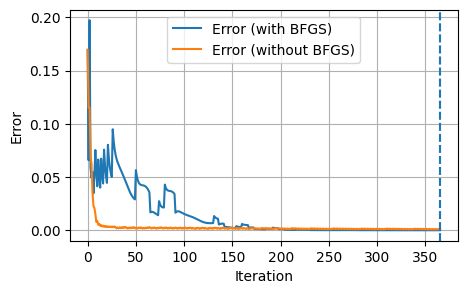

In [ ]:
plot_error(res_with_bfgs, res_without_bfgs, 'error_point_list', {'with': 'Error (with BFGS)', 'without': 'Error (without BFGS)'})

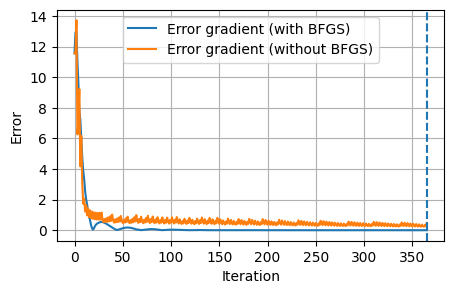

In [ ]:
plot_error(res_with_bfgs, res_without_bfgs, 'error_grad_list', {'with': 'Error gradient (with BFGS)', 'without': 'Error gradient (without BFGS)'})

You should observe plots similar to the ones below, where the number of iterations is significantly smaller:

![error.png](https://mcolom.perso.math.cnrs.fr/data/tps/optimisation/images/tp2/error.png)

The error between two consecutive solutions and gradient error (both computed by the L2 norm), with BFGS and without (standard gradient descent). The vertical lines correspond to the number of iterations performed up to convergence (dashed line for BFGS, and dotted line otherwise).


10) Which are in your opinion the main advantages and disadvantages of using BFGS?

# Advantages:
- The matrix $H$ is automatically positive definite.
- The computation of the descent direction is simpler.
- Fast convergence.
- We do not explicitly calculate second derivatives.

# Disadvantages:
- No quadratic convergence as in Newton's method.


# Constrained optimization (10pt)

## Functions

### Rosenbrock's banana

We start from the functions we used in the TP 1. Consider again the Rosenbrock's banana with $f: \mathbb{R}^2 \rightarrow \mathbb{R}: f(x_1,x_2) = (x_1-1)^2 + 100\, (x_1^2-x_2)^2$. Recall that $f \in \mathcal{C}^1(\mathbb{R}^2, \mathbb{R})$ is positive with a unique minimum at $x^* = (1,1)$, where $f(x^*) = 0$. The Python code for the function and its gradient follows.


In [ ]:
## Rosenbrock function and its gradient

def rosenbrock(x):
    y = np.asarray(x)
    return (y[0] - 1)**2 + 100 * (y[1] - y[0]**2)**2

def rosenbrock_grad(x):
    y = np.asarray(x)
    grad = np.zeros_like(y)
    grad[0] = 400 * y[0] * (y[0]**2 - y[1]) + 2 * (y[0] - 1)
    grad[1] = 200 * (y[1] - y[0]**2)
    return grad

### 2D Quadratic function

Recall also the quadratic function $f: \mathbb{R}^2 \rightarrow \mathbb{R}: f(x) = x^T A x$, with $A$ a diagonal matrix such that $A_{1,1} = m^2$, $A_{2,2} = M^2$, $(M,m) \in {\mathbb{R}_+^*}^2$, and all the other coefficients of the diagonal fixed to $1$. $f$ is strictly convex coercive and has a unique minimum at $0$. The Python code for this function and its gradient follows.

In [ ]:
def mk_quad(m, M, ndim=2):
  ## Quadratic function and its gradient
    def quad(x):
        y = np.copy(np.asarray(x))
        assert ndim == np.max(y.shape), "quad: wrong input dimension"
        scal = np.ones(y.shape)
        scal[0] = m
        scal[1] = M
        y *= scal
        return np.sum(y**2, 0)

    def quad_grad(x):
        y = np.asarray(x)
        assert ndim == np.max(y.shape), "quad_grad: wrong input dimension"
        scal = np.ones(y.shape)
        scal[0] = m ** 2
        scal[1] = M ** 2
        return 2 * scal * y

    return quad, quad_grad

## Projected gradient descent

![pgd_s.png](https://mcolom.perso.math.cnrs.fr/data/tps/optimisation/images/tp2/pgd_s.png)

Unconstrained optimization is straightforward to deploy. But, what happens when
there are constraints? The main idea behind projected gradient descent (PGD) is
to make sure that the point reached at each optimization step is _feasible_
or _valid_, i.e. satisfies a given set of rules. Since this cannot be
guaranteed by the standard Gradient Descent (GD) method, a solution to achieve
it is by projecting an infeasible point reached at an optimization step back to
the feasible set $\mathcal{X}$. A representation with an elliptic feasible set
is shown on the above. Note that, depending on the complexity of the problem, it
may be only possible to approximate the best projection point (shown with dotted
line in the figure) rather than finding it exactly.

### Feasible set in an Euclidean ball

Suppose that the feasible set $\mathcal{X}$ of our interest can be identified inside a multidimensional Euclidean ball. Assuming a center $c \in \mathbb{R}^n$ and a radius $r \in \mathbb{R}$, such a ball is defined as:
\begin{equation}\label{eq:ball}
f_{c,r}: \mathbb{R}^n \rightarrow \mathbb{R}: f_{c,r}(x) = \| x - c \|^2 - r^2.
\end{equation}
Note that $f$ is positive for all points farther than $r$ from the center $c$, thus we can write directly $\mathcal{X} = \{\forall x\in\mathbb{R}^n: f_{c,r}(x,c) \leq 0\}$.

The most complicated part of this approach is to compute the _projection step_. In the discussed case: for any given point $x\in \mathbb{R}^n$, the projection operator $\text{proj}_\mathcal{X}(x)$ can be defined as:
\begin{equation}
\text{proj}_\mathcal{X}(x) =                    
\left\{
\begin{array}{ll}
      x, & f_{c,r}(x) \leq 0, \\
      \mathrm{argmin}_{x'\in\mathcal{X}} ||x-x'||, & f_{c,r}(x) > 0.
\end{array}
\right.
\end{equation}
More specifically, the second branch computes the properly projected $x'$ as:
\begin{equation}
x' = c + r \frac{x - c}{||x - c||}.
\end{equation}
The python code that follows describes the main constraint elements needed by the PDG. Implement the missing (``<TODO>``) parts.

In [ ]:
# Feasible set in an Euclidean ball

def ball_constraint(center, radius):
    def ball(x):         # the ball function
        return(np.linalg.norm(x-center)**2-radius**2)

    def ball_grad(x):    # the ball gradient
        return(2*(x-center))

    def ball_proj(x):    # the projection on the ball
        if ball(x)<=0:
          return(x)
        else:
          return(center+radius*(x-center)/np.linalg.norm(x-center))

    return ball, ball_grad, ball_proj

### Implementation of the PGD

Now, it's time to implement this iterative method in the following function. It has the same inputs as in the previous exercise), with the additional ``constraint_proj`` which is the $\text{proj}_\mathcal{X}$ projection operator. Implement also a termination rule combining the distance $||x_{k-1} - x_k||$ and the norm of the gradient $||\nabla f(x_{k})||$ (using respectively the threshold pars: ``error_point``, ``error_grad``).

In [ ]:
# Projected gradient descend method

def proj_grad(f, grad, x0, iterations, error_point, error_grad, constraint_proj, hstep):
    # Memory allocation
    dim = np.max(np.shape(x0))               # dimensions of the space
    x_list = np.zeros([dim, iterations])     # solution at each iteration
    f_list = np.zeros(iterations)            # f. value at each solution point
    error_point_list = np.zeros(iterations)  # error of solutions
    error_grad_list = np.zeros(iterations)   # error of the gradient

    # Initialization
    x = x0
    x_old = np.copy(x)
    grad_x = grad(x)
    d_x = -grad_x
    f_x = f(x)

    # Iterative optimization
    for i in range(iterations):
        y=x+hstep*d_x
        x=constraint_proj(y)
        grad_x = grad(x)
        d_x = -grad_x
        f_x = f(x)

        # Log results
        x_list[:, i] = np.reshape(x, -1)
        f_list[i] = f_x
        error_point_list[i] = np.linalg.norm(x - x_old)
        error_grad_list[i] = np.linalg.norm(grad(x))

        if error_point_list[i]<error_point or error_grad_list[i]<error_grad:
          break
        x_old = np.copy(x)
    return {'x_list': x_list[:, 0:i], 'f_list': f_list[0:i], 'error_point_list': error_point_list[0:i], 'error_grad_list': error_grad_list[0:i]}

## Augmented Lagrangian-like methods

This class of methods replaces a constrained optimization problem by a series of unconstrained problems. It also adds a penalty term to the Lagrangian objective (augmentation) based on a non-negative and continuous penalty function. For the case of minimization, the penalty term would get low values (up to zero) for a solution that respects the constraints (i.e. $x \in \mathcal{X})$, and would get higher values the more the solutions violate the constraints.

Algorithmically, the basic idea is that we can start with an unconstrained problem defined by a mild penalty term, the solution of which can be the initial point for a successive unconstrained problem with stricter penalty term. Continuing this process, while also making more strict the penalty, leads to solutions that respect the constraints more and more, and the method finally converges. With proper simplifications, we describe below the penalty and the barrier methods that can be seen as simple cases following this strategy.

### Penalty method

We can write the penalty problem $P$ of round $i$ with a parameter $\sigma_i > 0$ as:
\begin{equation}\label{eq:main}
P(\sigma_i): \min_x \left\lbrace f(x) + \sigma_i \, p(x) \right\rbrace,
\end{equation}
where $\sigma_i \, p(x)$ is the _penalty term_, $p(x)$ is the _external penalty function_ and $\sigma_i$ its _penalty coefficient_. For large $\sigma_i$ the minimizer of the problem $P(\sigma_i)$ will be in a region in which $p(x)$ is small and thus the constraints are respected. As explained, the method deploys successively: a series of (inner or sub) iterations are performed with a fixed $\sigma$ and the solution is fed to the next round that will use an updated $\sigma_{i+1}$. As $\sigma \rightarrow \infty$, the solution of the penalty problem $P(\sigma)$ will converge to a solution of the original constrained problem. An illustration of this process is shown in the figure below.

![penalty_s.png](https://mcolom.perso.math.cnrs.fr/data/tps/optimisation/images/tp2/penalty_s.png)

In practice, for $\mathcal{X}$ identified by the $f_{c,r}$ of a ball, we can start with $\sigma_0 = 1$ and consider the update $\sigma_i = 2\,\sigma_{i-1}$. Then, in the general penalty function
\begin{equation} \label{eq:p_x}
p(x) = -(\nabla f(x) + \sigma_i \,g(x)),
\end{equation}
one needs to use the specific $g$ for the penalty method. For instance,
\begin{equation}
g_{\text{penalty}}(x) =                         
\left\{
\begin{array}{ll}
      2 \, f_{c,r}(x) \, \nabla f_{c,r}(x), & f_{c,r}(x) > 0, \\
      0, & f_{c,r}(x) \leq 0.
\end{array}
\right.
\end{equation}
At each inner iteration we get
- $x = x + h \,\Delta x$      
- $\Delta x = p(x)$.

### Barrier (or interior-point) method

For this approach, we can follow exactly the same framework defined above. The steps for updating $x$ and $\Delta x$ in each inner iteration are also the same. The difference to the penalty method, though, is that (due to the different $g$) $\sigma$ decreases throughout rounds: we can start with $\sigma_0 = 100$ and use the update $\sigma_i = \frac{1}{2}\,\sigma_{i-1}$. Finally, the $g$ that should be used is the following:
\begin{equation}
g_{\text{barrier}}(x) = -\frac{\nabla f_{c,r}(x)}{f_{c,r}(x)}.
\end{equation}

### Implementation

First, let's extend the ``ball_constraint`` section we saw earlier by including the two functions, $g_{\text{penalty}}$ and $g_{\text{update}}$.


In [ ]:
# Feasible set in an Euclidean ball

def ball_constraint(center, radius):
    #... <ball, ball_grad, ball_proj, as before> ...
    def ball(x):         # the ball function
        return(np.linalg.norm(x-center)**2-radius**2)

    def ball_grad(x):    # the ball gradient
        return(x-center)

    def ball_proj(x):    # the projection on the ball
        if ball(x)<=0:
          return(x)
        else:
          return(center+radius*(x-center)/np.linalg.norm(x-center))

    def g_penalty(x):
        ball_x=ball(x)
        if ball_x>0:
          ball_grad_x=ball_grad(x)
          return(2*ball_x*ball_grad_x)
        else:
          return(0)

    def g_barrier(x):
        ball_x=ball(x)
        ball_grad_x=ball_grad(x)
        return(-ball_grad_x/ball_x)

    return ball, ball_grad, ball_proj, g_penalty, g_barrier

Then, add the two following functions that apply the respective updates to $\sigma_{i+1}$. These will be called in each round.

In [ ]:
# Special functions for the Penalty and Barrier methods

def sigma_update_penalty(sigma):
    return(2*sigma)

def sigma_update_barrier(sigma):
    return(sigma/2)

Now, fill the (``<TODO>``) parts in the following function; it is a general optimizer that can apply any of the two augmented Lagrangian-like methods we have seen (i.e. the penalty of the barrier methods). Note that there is a nested loop: the outer one represents one round that first sets/updates the $\sigma_i$ and then the inner (sub)iterations take over to perform the unconstrained optimization. The solution of one round will be the initialization point of the the next one.

In [ ]:
# A general optimizer: it can implement the penalty and barrier methods

def general_optimizer(f, grad, x0, iterations, iterations_sub, error_point, error_grad, sigma0, sigma_update, grad_fun, hstep):
    # Memory allocation
    dim = np.max(np.shape(x0))
    x_list = np.zeros([dim, iterations])
    f_list = np.zeros(iterations)
    error_point_list = np.zeros(iterations)
    error_grad_list = np.zeros(iterations)

    # Initialization
    x = x0
    x_old = np.copy(x)
    grad_x = grad(x)
    g_x = grad_fun(x)
    d_x=-grad_x
    f_x = f(x)

    # Iterative optimization
    sigma = sigma0
    for i in range(iterations):
        sigma = sigma_update(sigma)          # update $\sigma_i$
        # solve iteratively the unconstrained problem $P(\sigma_i)$
        for k in range(iterations_sub):
            x=x+hstep*d_x
            grad_x = grad(x)
            g_x = grad_fun(x)
            d_x=-(grad_x+sigma*g_x)
            f_x = f(x)

            # Log results
            x_list[:, i] = np.reshape(x, -1)
            f_list[i] = f_x
            error_point_list[i] = np.linalg.norm(x - x_old)
            error_grad_list[i] = np.linalg.norm(grad(x))

            if error_point_list[i]<error_point or error_grad_list[i]<error_grad:    # termination condition
                break
            x_old = np.copy(x)

    return {'x_list': x_list[:, 0:i], 'f_list': f_list[0:i], 'error_point_list': error_point_list[0:i], 'error_grad_list': error_grad_list[0:i]}

The following functions allow you to report formatted optimization results.

In [ ]:
# Function to output formatted results

def show_results(method_name, results):
    print(f"\n*** {method_name}")
    print(f"number iterations: {len(result['x_list'][0, :])+1}")
    print(f"end value (function): {result['f_list'][-1]}")
    print(f"end position: {result['x_list'][:, -1]}")

## Constrained optimization in action

### Sanity check with constraints inside an Euclidean ball

At this
point you need to do a 'sanity check' to check if the coded methods are
correct. The setup is to optimize an easy quadratic function. After filling the
little missing (``<TODO>``) parts, when you run the following code, you
can see all methods converging to the value 0.25. What do you observe in the
results you obtain?

In [ ]:
# Sanity check for constraints inside a ball

# Setup: optimize a quadratic function
f, grad = mk_quad(1, 5)
x0 = np.array([1, .25])
error_point = 10**-10
error_grad = 10**-10

constraint_fun, _, constraint_proj, g_penalty, g_barrier = ball_constraint(np.array([1, 0]), 0.5)

iterations = 1000
hstep = 10**(-2)

result = proj_grad(f, grad, x0, iterations, error_point, error_grad, constraint_proj, hstep)
show_results('Projected gradient method', result)

#--
iterations_sub = iterations
iterations = 20
hstep = 10**(-4)

sigma0 = 1
result = general_optimizer(f, grad, x0, iterations, iterations_sub, error_point, error_grad, sigma0, sigma_update_penalty, g_penalty, hstep)
show_results('Penalty method', result)

sigma0 = 100
result = general_optimizer(f, grad, x0, iterations, iterations_sub, error_point, error_grad, sigma0, sigma_update_barrier, g_barrier, hstep)
show_results('Barrier method', result)


*** Projected gradient method
number iterations: 36
end value (function): 0.25
end position: [5.00000000e-01 7.17655686e-12]

*** Penalty method
number iterations: 20
end value (function): 0.2517759804157127
end position: [5.01772837e-01 1.81175161e-30]

*** Barrier method
number iterations: 20
end value (function): 0.2500953492533701
end position: [5.00095340e-01 2.77829865e-46]


We observe that the three methods give identical results, but the "Penalty" and "Barrier" methods are slightly faster (20 iterations compared to 36).


Try to repeat all the above for the Rosenbrock's banana function, and let the methods start at $x_0 = [1.1, 2.1]$. What do you observe?

In [ ]:
# Sanity check for constraints inside a ball

# Setup: optimize a quadratic function
f, grad = rosenbrock,rosenbrock_grad
x0 = np.array([1.1, 2.1])
error_point = 10**-10
error_grad = 10**-10

constraint_fun, _, constraint_proj, g_penalty, g_barrier = ball_constraint(np.array([1, 0]), 0.5)

iterations = 1000
hstep = 10**(-2)

result = proj_grad(f, grad, x0, iterations, error_point, error_grad, constraint_proj, hstep)
show_results('Projected gradient method', result)

#--
iterations_sub = iterations
iterations = 20
hstep = 10**(-4)

sigma0 = 1
result = general_optimizer(f, grad, x0, iterations, iterations_sub, error_point, error_grad, sigma0, sigma_update_penalty, g_penalty, hstep)
show_results('Penalty method', result)

sigma0 = 100
result = general_optimizer(f, grad, x0, iterations, iterations_sub, error_point, error_grad, sigma0, sigma_update_barrier, g_barrier, hstep)
show_results('Barrier method', result)


*** Projected gradient method
number iterations: 50
end value (function): 0.497665160810274
end position: [0.6192988  0.32413978]

*** Penalty method
number iterations: 20
end value (function): 1.7506369840292848
end position: [0.64419426 0.28754845]

*** Barrier method
number iterations: 20
end value (function): 0.9594434018706485
end position: [1.97923575 3.91969955]


The three methods yield completely different results: it is quite curious because the final points are fairly close for the projected gradient and the "penalty" method, but they return significantly different function values. As for the barrier method, it results in a completely different outcome. Probably, the banana function "disrupts" these algorithms.


### Solving a problem with a complex feasibility set

Suppose the feasibility set is the non-empty intersection between two balls of radius 0.5 and centers [1, 0] and [1, 0.5], respectively. Fill the (``<TODO>``) parts in the following code and report your observations. Note that in the reported results it is shown the evaluation of the two constraint functions at the final point, that is ball$_1(x^*)$ and ball$_2(x^*)$ (see the definition of the ball $f_{c,r}$ above).

In [ ]:
# A more complex example: feasible set at the intersection of two balls

# Get a different constraint set for each ball
constraint_fun1, _, _, g_penalty1, g_barrier1 = ball_constraint(np.array([1, 0]), 0.5)
constraint_fun2, _, _, g_penalty2, g_barrier2 = ball_constraint(np.array([1, 0.5]), 0.5)

# Redefine the external penalty functions
def g_penalty(x):
    return g_penalty1(x) + g_penalty2(x)

def g_barrier(x):
    return g_barrier1(x) + g_barrier2(x)

iterations = 20
iterations_sub = 1000
hstep = 10**(-5)


# Setup: optimize a quadratic function
f, grad = mk_quad(1, 5)
x0 = np.array([1, .25])
error_point = 10**-10
error_grad = 10**-10


sigma0 = 1
result = general_optimizer(f, grad, x0, iterations, iterations_sub, error_point, error_grad, sigma0, sigma_update_penalty, g_penalty, hstep)
show_results('Penalty method', result)
print(f"constraint 1; {constraint_fun1(result['x_list'][:, -1])}")
print(f"constraint 2; {constraint_fun2(result['x_list'][:, -1])}")

sigma0 = 100
result = general_optimizer(f, grad, x0, iterations, iterations_sub, error_point, error_grad, sigma0, sigma_update_barrier, g_barrier, hstep)
show_results('Barrier method', result)
print(f"constraint 1; {constraint_fun1(result['x_list'][:, -1])}")
print(f"constraint 2; {constraint_fun2(result['x_list'][:, -1])}")


*** Penalty method
number iterations: 20
end value (function): 0.6736308803194633
end position: [0.78073582 0.05062903]
constraint 1; -0.19935992044247233
constraint 2; 1.1051769868208883e-05

*** Barrier method
number iterations: 20
end value (function): 0.6838608217223012
end position: [0.80031095 0.04164767]
constraint 1; -0.2083897541981221
constraint 2; -3.742312589793961e-05


We notice that the results are almost identical, achieved in a reasonable number of iterations, and the final point is indeed within the non-empty intersection of the two balls: this is very satisfying.
